In [1]:
import cv2
import numpy as np
from glob import glob
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
class Inferer:

    def __init__(self):
        self.model = None

    def build_model(self, num_rrg: int, num_mrb: int, channels: int, weights_path: str):
        self.model = mirnet_model(image_size=None, num_rrg=num_rrg,num_mrb=num_mrb, channels=channels)
        self.model.load_weights(weights_path)

    def _predict(self, original_image, image_resize_factor: float = 1.):
        width, height = original_image.size
        target_width, target_height = (closest_number(width // image_resize_factor, 4),closest_number(height // image_resize_factor, 4))
        original_image = original_image.resize((target_width, target_height), Image.ANTIALIAS)
        image = tf.keras.preprocessing.image.img_to_array(original_image)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=0)
        output = self.model.predict(image)
        output_image = output[0] * 255.0
        output_image = output_image.clip(0, 255)
        output_image = output_image.reshape((np.shape(output_image)[0], np.shape(output_image)[1], 3))
        output_image = Image.fromarray(np.uint8(output_image))
        original_image = Image.fromarray(np.uint8(original_image))
        return output_image

    def infer(self, image_path, image_resize_factor: float = 1.):
        original_image = Image.open(image_path)
        output_image = self._predict(original_image, image_resize_factor)
        return original_image, output_image

    def infer_streamlit(self, image_pil, image_resize_factor: float = 1.):
        original_image = image_pil
        output_image = self._predict(original_image, image_resize_factor)
        return original_image, output_image

In [4]:
def mirnet_model(image_size: int, num_rrg: int, num_mrb: int, channels: int):
    input_tensor = tf.keras.Input(shape=[image_size, image_size, 3])
    x1 = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = tf.keras.layers.Conv2D(3, kernel_size=(3, 3), padding='same')(x1)
    output_tensor = tf.keras.layers.Add()([input_tensor, conv])
    return tf.keras.Model(input_tensor, output_tensor)

In [5]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(conv1)
    return tf.keras.layers.Add()([conv2, input_tensor])

In [6]:
def down_sampling_module(input_tensor):
    """Downsampling Module"""
    channels = list(input_tensor.shape)[-1]
    main_branch = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(input_tensor)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(main_branch)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.MaxPooling2D()(main_branch)
    main_branch = tf.keras.layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = tf.keras.layers.MaxPooling2D()(input_tensor)
    skip_branch = tf.keras.layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return tf.keras.layers.Add()([skip_branch, main_branch])

In [7]:
def __init__(self):
    self.model = None
    self.crop_size = None
    self.train_dataset = None
    self.valid_dataset = None

In [8]:
def dual_attention_unit_block(input_tensor):
    """Dual Attention Unit Block"""
    channels = list(input_tensor.shape)[-1]
    feature_map = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(input_tensor)
    feature_map = tf.keras.layers.ReLU()(feature_map)
    feature_map = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(feature_map)
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = tf.keras.layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return tf.keras.layers.Add()([input_tensor, concatenation])

In [9]:
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(level1_dau, up_sampling_module(level2_dau),up_sampling_module(up_sampling_module(level3_dau)))
    level2_skff = selective_kernel_feature_fusion(down_sampling_module(level1_dau), level2_dau,up_sampling_module(level3_dau))
    level3_skff = selective_kernel_feature_fusion(down_sampling_module(down_sampling_module(level1_dau)),down_sampling_module(level2_dau), level3_dau)
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(up_sampling_module(dual_attention_unit_block(level3_skff)))
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
    conv = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(skff_)
    return tf.keras.layers.Add()([input_tensor, conv])

In [10]:
def channel_attention_block(input_tensor):
    """Channel Attention Block"""
    channels = list(input_tensor.shape)[-1]
    average_pooling = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = tf.keras.layers.ReLU()(tf.keras.layers.Conv2D(filters=channels // 8, kernel_size=(1, 1))(feature_descriptor))
    feature_activations = tf.nn.sigmoid(tf.keras.layers.Conv2D(filters=channels, kernel_size=(1, 1))(feature_activations))
    return input_tensor * feature_activations

In [11]:
def spatial_attention_block(input_tensor):
    """Spatial Attention Block"""
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = tf.keras.layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


In [12]:
def selective_kernel_feature_fusion(
        multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
    """Selective Kernel Feature Fusion Block"""
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = tf.keras.layers.Add()([multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])
    gap = tf.keras.layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = tf.keras.layers.ReLU()(tf.keras.layers.Conv2D(filters=channels // 8, kernel_size=(1, 1))(channel_wise_statistics))
    feature_descriptor_1 = tf.nn.softmax(tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation))
    feature_descriptor_2 = tf.nn.softmax(tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation))
    feature_descriptor_3 = tf.nn.softmax(tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation))
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = tf.keras.layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [13]:
def up_sampling_module(input_tensor):
    """Upsampling Module"""
    channels = list(input_tensor.shape)[-1]
    main_branch = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(input_tensor)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(main_branch)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.UpSampling2D()(main_branch)
    main_branch = tf.keras.layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = tf.keras.layers.UpSampling2D()(input_tensor)
    skip_branch = tf.keras.layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return tf.keras.layers.Add()([skip_branch, main_branch])

In [14]:
model = mirnet_model(256 , num_rrg=3, num_mrb=2, channels=64)
inferer = Inferer()
inferer.build_model(num_rrg=3, num_mrb=2, channels=64,weights_path='low_light_weights_best.h5')

In [15]:
def closest_number(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = (m * (q + 1))
    else:
        n2 = (m * (q - 1))
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

In [16]:
def plot_result(image, enhanced):
    """Utility for Plotting inference result
    Args:
        image: original image
        enhanced: enhanced image
    """
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 2, 1).set_title('Original Image')
    _ = plt.imshow(image)
    fig.add_subplot(1, 2, 2).set_title('Enhanced and Sharpened Image')
    _ = plt.imshow(enhanced)
    plt.show()

In [17]:
from ISR.models import RDN

rdn = RDN(weights='psnr-small')

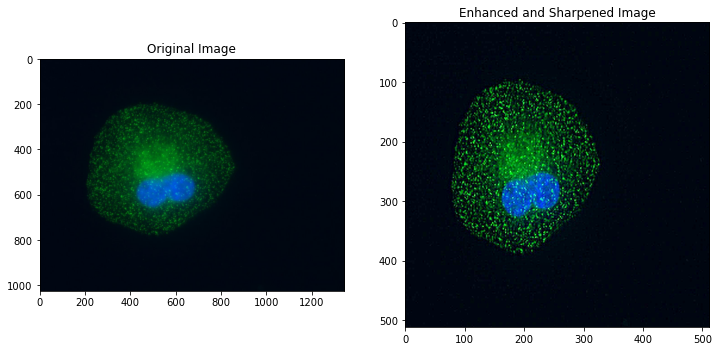

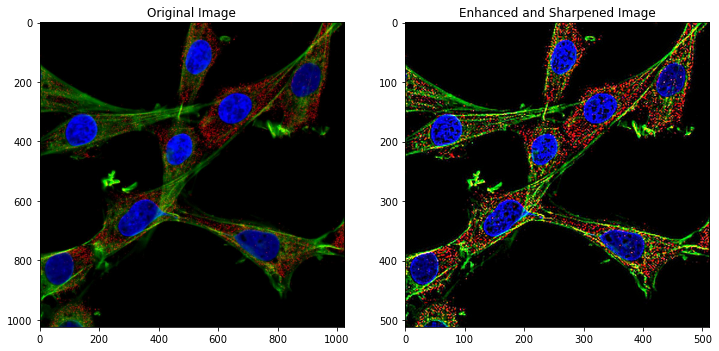

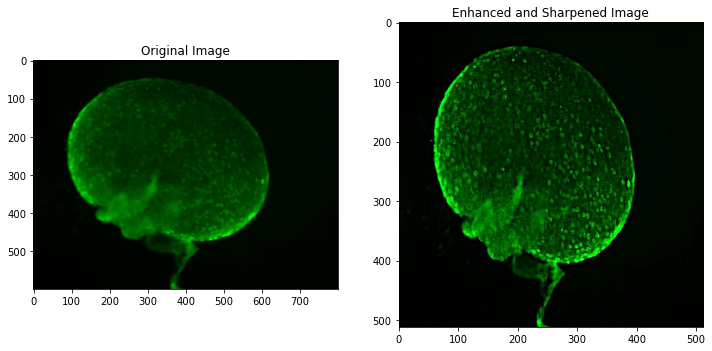

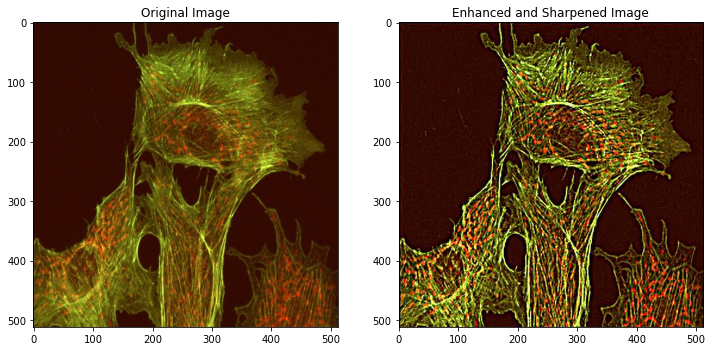

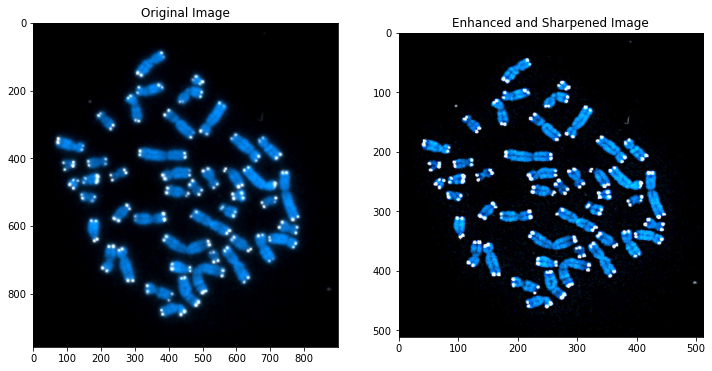

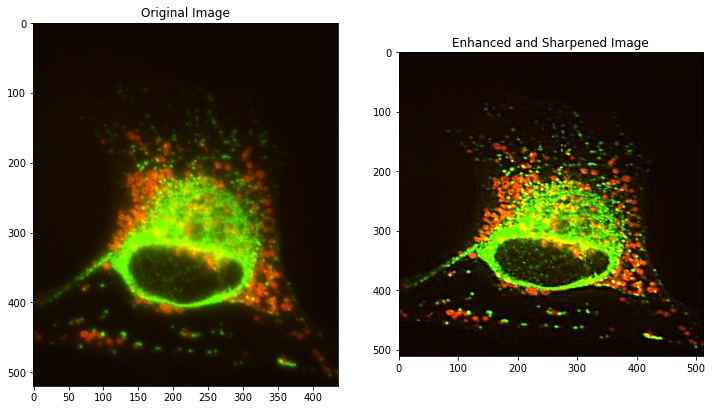

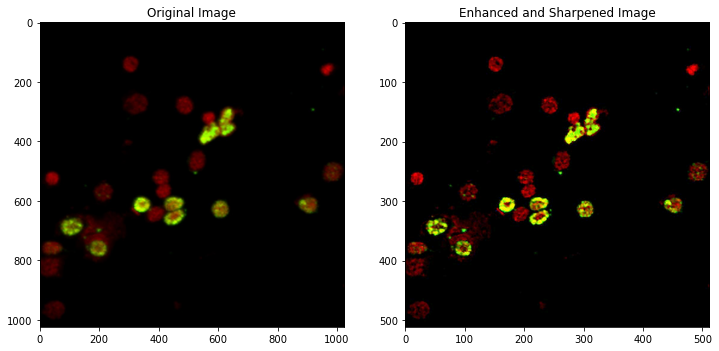

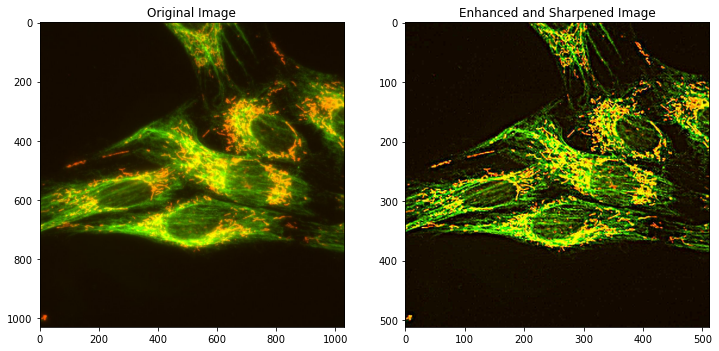

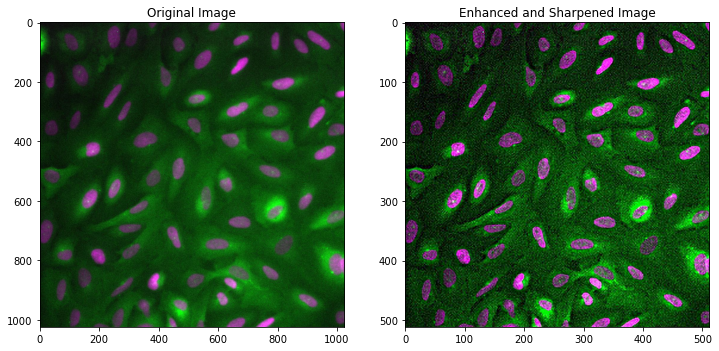

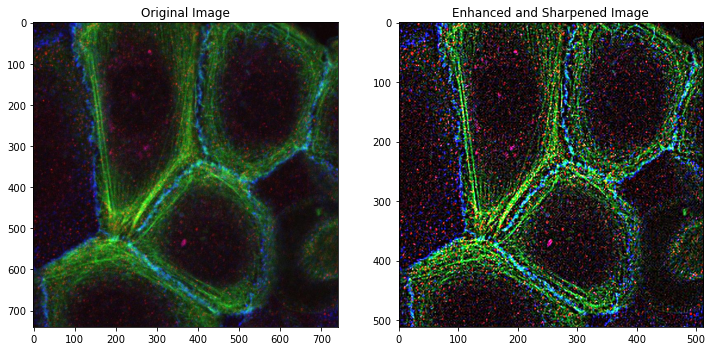

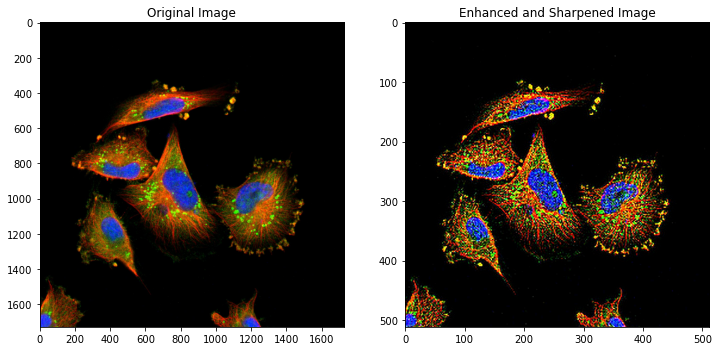

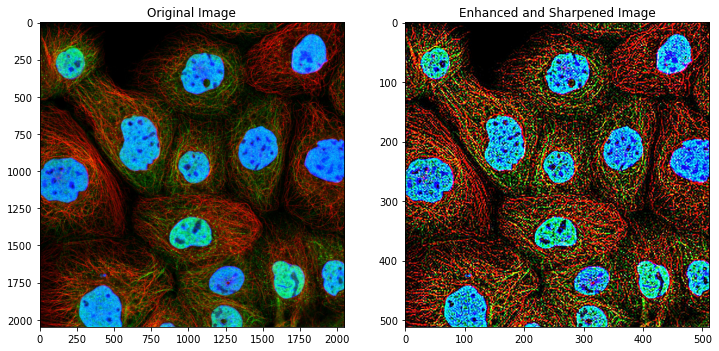

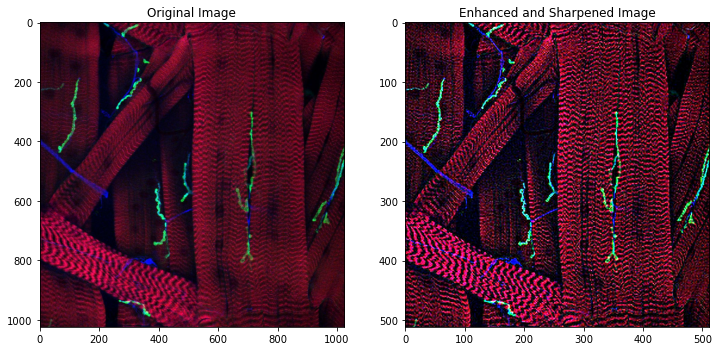

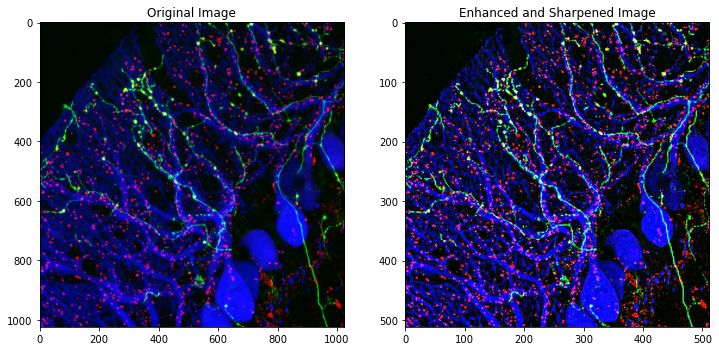

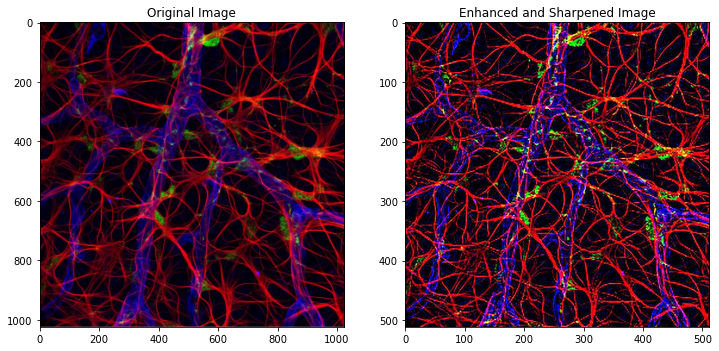

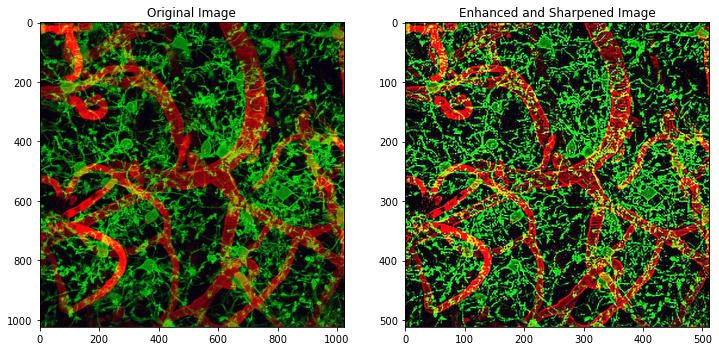

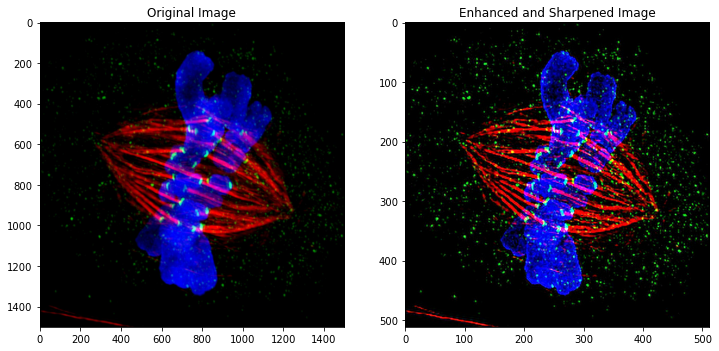

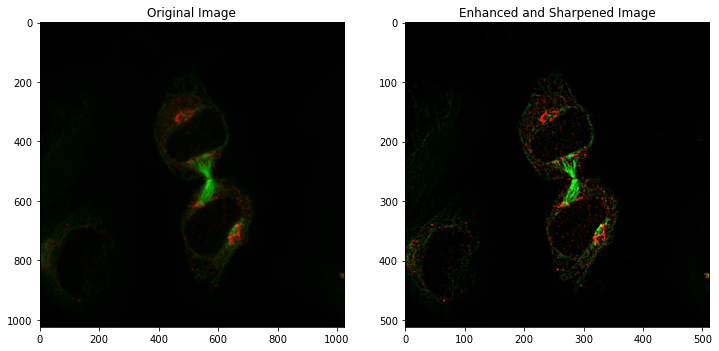

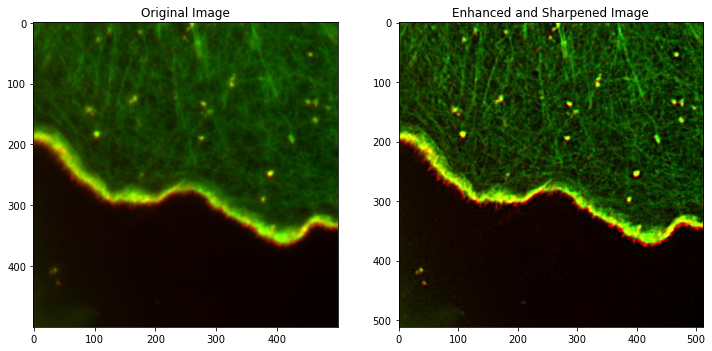

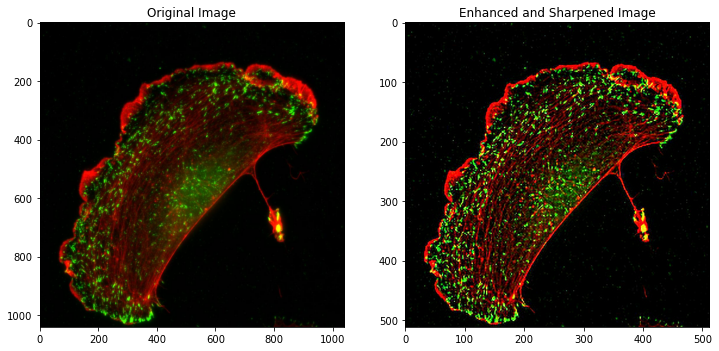

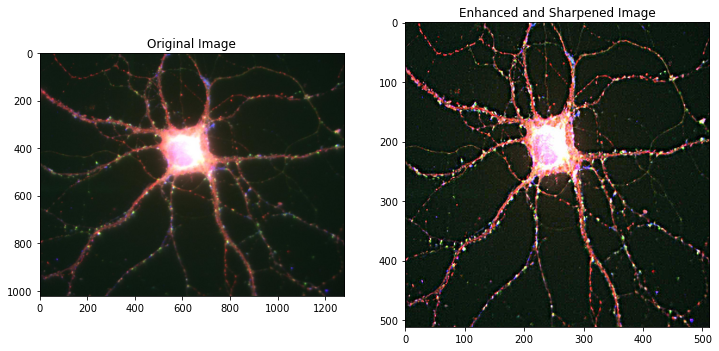

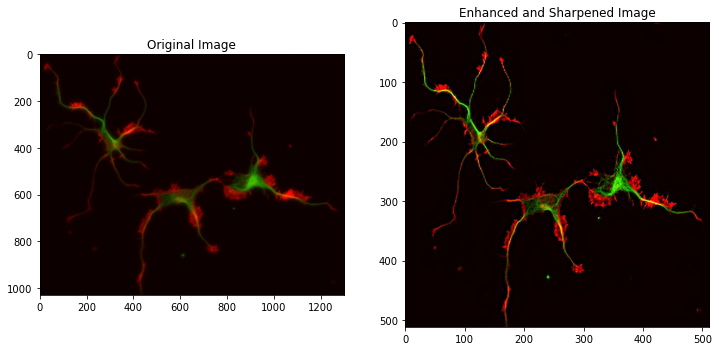

In [18]:
tif = glob("temp/*")
for path in tif:
    img = Image.open(path)
    converted = np.array(img)
    converted = cv2.resize(converted, (256, 256))
    gaussian_blur = cv2.GaussianBlur(converted , (7,7), 2)
    converted = cv2.addWeighted(converted ,3.5, gaussian_blur, -2.5, 0)
    converted = rdn.predict(converted)
    sharpened2 = Image.fromarray(converted)
    plot_result(img, sharpened2)